In [121]:
import os
import cv2 as cv
import numpy
import pylab
from vidstab import VidStab

import imageio
from scipy.misc import imresize
from matplotlib import pyplot as plt
%pylab inline



os.chdir('/home/kaigang/Desktop/MLB/')
from importlib import reload
import Code.params;reload(Code.params)
from Code.params import TEST_LINKS,TEST_RESIZED,MASKS_FILES
import Code.research;reload(Code.research)
from Code.research import resize_videos,get_flow

Populating the interactive namespace from numpy and matplotlib


# import/check/resize DATA

In [2]:
for file in TEST_LINKS:
    vid = imageio.get_reader(file,  'ffmpeg')
    print(file)
    print('vid length is %s' % vid.get_length())
    print('fps is %s' % vid.get_meta_data()['fps'])
    print('duration is %s' % vid.get_meta_data()['duration'])

/home/kaigang/Desktop/MLB/Data/test1.mp4
vid length is 600
fps is 59.94
duration is 10.01
/home/kaigang/Desktop/MLB/Data/test2.mp4
vid length is 1199
fps is 59.94
duration is 20.0
/home/kaigang/Desktop/MLB/Data/test3.mp4
vid length is 900
fps is 59.94
duration is 15.02
/home/kaigang/Desktop/MLB/Data/test4.mp4
vid length is 900
fps is 59.94
duration is 15.02
/home/kaigang/Desktop/MLB/Data/test5.mp4
vid length is 1199
fps is 59.94
duration is 20.0


## resize videos to reduce computional complexity
optional, or run it only once

In [3]:
if False:
    resize_videos(TEST_LINKS,height = 720)

# Optical flow

In [5]:
if False:
    for file in TEST_RESIZED(360):
        a = get_flow(file)

# Line detection on aggregated flow mask
1. I'm assuming the ball trajectory, projecting back to image plane in a pin-hole camera system (perspective projection), is a straight line 
2. It's defintely not 100% accurate. But I think it's a good way of reducing the complexity (no need to think about the fluid dynamics and etc)
3. To account for the simplification, we can try use some smoothing using morphological transformations. 

In [29]:
img = cv.imread(MASKS_FILES(360)[0])

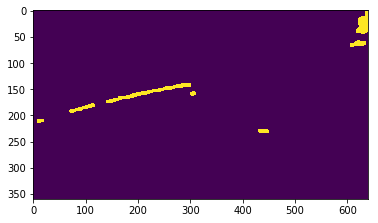

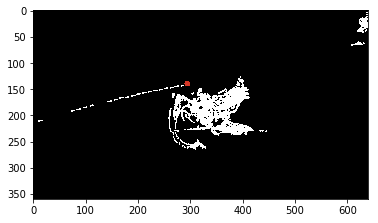

In [116]:
# for i in range(5):
img = cv.imread(MASKS_FILES(360)[3])
img_bw = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
kernel = np.ones((5,5),np.uint8)
opening = cv.dilate(img_bw, kernel).astype( 'uint8' )
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(opening, connectivity=4)
largest_label = 1 + np.argmax(stats[1:, cv.CC_STAT_AREA])
opening[output==largest_label]=0
plt.figure()
plt.imshow(opening)
erosion = cv.erode(opening,kernel,iterations = 1)
low_threshold = 50
high_threshold = 150
edges = cv.Canny(erosion, low_threshold, high_threshold)
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 30  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 60  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(img) * 0  # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

x_start = img.shape[1]
y_start = 0
x_end = 0
y_end = img.shape[0]
for line in lines:
    for x1,y1,x2,y2 in line:
#         cv.line(line_image,(x1,y1),(x2,y2),(255,0,0),1)
        x_start = min(x1,x_start)
        y_start = max(y1,y_start)
        x_end = max(x_end,x2)
        y_end = min(y_end,y2)
# Draw the lines on the  image
cv.line(line_image,(x_start,y_start),(x_end,y_end),(255,0,0),5)
# Draw the lines on the  image
lines_edges = cv.addWeighted(img, 0.8, line_image, 1, 0)
lines_edges = cv.circle(img,(x_end,y_end),5,color[i].tolist(),-1)
plt.figure()
plt.imshow(lines_edges)
#     cv.imwrite(str(i)+'_.png',lines_edges)

In [117]:
file = TEST_RESIZED(360)[3]


In [118]:
cap = cv.VideoCapture(file)
vid = imageio.get_reader(file, 'ffmpeg')
dist = 1000
# params for ShiTomasi corner detection
feature_params = dict(maxCorners=100,
                      qualityLevel=0.3,
                      minDistance=3,
                      blockSize=7)
# Parameters for lucas kanade optical flow
lk_params = dict(winSize=(15, 15),
                 maxLevel=2,
                 criteria=(cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
color = np.random.randint(0, 255, (100, 3))

first_frame = vid.get_data(index=1)
mask = np.zeros_like(first_frame)
for i in range(int(vid.get_length()/2)):
    cur = vid.get_data(index=2*i)
    next = vid.get_data(index=2*i+1)
    cur_gray = cv.cvtColor(cur,cv.COLOR_BGR2GRAY)
    next_gray = cv.cvtColor(next,cv.COLOR_BGR2GRAY)
    p0 = cv.goodFeaturesToTrack(cur_gray, mask = None, **feature_params)
    p1, st, err = cv.calcOpticalFlowPyrLK(cur_gray, next_gray, p0, None, **lk_params)
    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]
    for i,(new,old) in enumerate(zip(good_new,good_old)):

        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv.line(mask, (a,b),(c,d), [255,255,255], 2)
        temp = np.sqrt(np.power(x_end-a,2)+np.power(y_end-b,2))
        if temp<dist:
            res = i
            dist = temp
            frame_release = cv.circle(cur,(x_end,y_end),5,color[i].tolist(),-1)

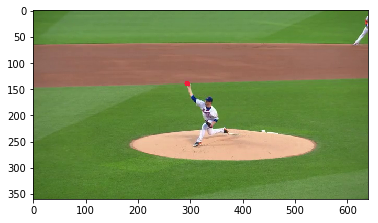

In [119]:
plt.imshow(frame_release)

In [122]:
res

14

# Video stablization 
Stablizing videos in a rigid euclidean transform since the camera is more or less stable. method explaination: http://nghiaho.com/?p=2093

In [4]:
from vidstab import VidStab

In [5]:
TEST_RESIZED[0]

'/home/kaigang/Desktop/MLB/Data/test1_stable.mp4'

In [6]:
cap = cv.VideoCapture(TEST_LINKS[1])


In [7]:
ret, frame1 = cap.read()
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

In [11]:
return 

(2160, 3840, 2)

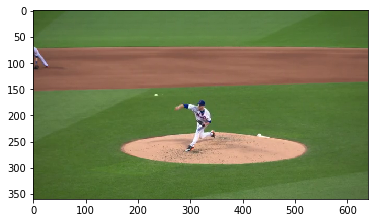

In [16]:
vid = imageio.get_reader(TEST_RESIZED[0],  'ffmpeg')
img = vid.get_data(index = 450)

plt.imshow(img)

# background subtraction